In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('default')

In [2]:
csvfile = '../csv/alldata.csv'
distance_param = 'CDistance'
tragitti = pd.read_csv(csvfile, index_col=False)

pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] < 13)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)

def clean(df):
    hour_cond = df['Hour'] != 0
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = hour_cond & distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [3]:
tragitti = tragitti[post_lock_cond]
tragitti = tragitti[clean(tragitti)]

replace = {}
replace['Car'] = 'Auto'
replace['Public'] = 'ATM'
replace['Bike'] = 'Bici'
replace['Foot'] = 'A piedi'
replace['Enjoy'] = 'Enjoy'

colori = ['slategray', 'firebrick', 'darkorange', 'limegreen', 'slateblue']
myindex = [
    '7:00', '8:00', '9:00', '10:00',
    '11:00', '12:00', '13:00', '14:00',
    '15:00','16:00', '17:00', '18:00',
    '19:00', '20:00', '21:00', '22:00',
    '23:00']
plterrindex = [
    '10:00', '11:00', '12:00', '13:00',
    '14:00', '15:00','16:00', '17:00',
    '18:00', '19:00', '20:00', '21:00',
    '22:00', '23:00', '7:00', '8:00',
    '9:00'] # pyplot stupido

def list_minus(l1, l2):
    r = []
    for i in range(0, len(l1)):
        r.append(l1[i] - l2[i])
    return r

def vmedia_week(df, mezzo):    
    lst = vmedia_week_list(df, mezzo)
    array = np.array(lst).T
    return pd.DataFrame(array, index=myindex, columns=[replace[mezzo]]).round(1)

def vmedia_week_list(df, mezzo):    
    return vmedia_giorno(df, mezzo)

def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore

def vstd_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(2 * np.std(velocita_media_oraria, ddof=1))
    return vmedia_giorno_ore

def week_filters(df):
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(4, 8)) |
            (df['Day'].between(11, 15)) |
            (df['Day'].between(18, 22)) |
            (df['Day'].between(25, 29)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 5)) |
            (df['Day'].between(8, 12)) |
            (df['Day'].between(15, 19)) |
            (df['Day'].between(22, 26))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(9, 10)) |
            (df['Day'].between(16, 17)) |
            (df['Day'].between(23, 24)) |
            (df['Day'].between(30, 31)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(6, 7)) |
            (df['Day'].between(13, 14)) |
            (df['Day'].between(20, 21)) |
            (df['Day'].between(27, 28))))
    
    return weeks, weekends

w, we = week_filters(tragitti)

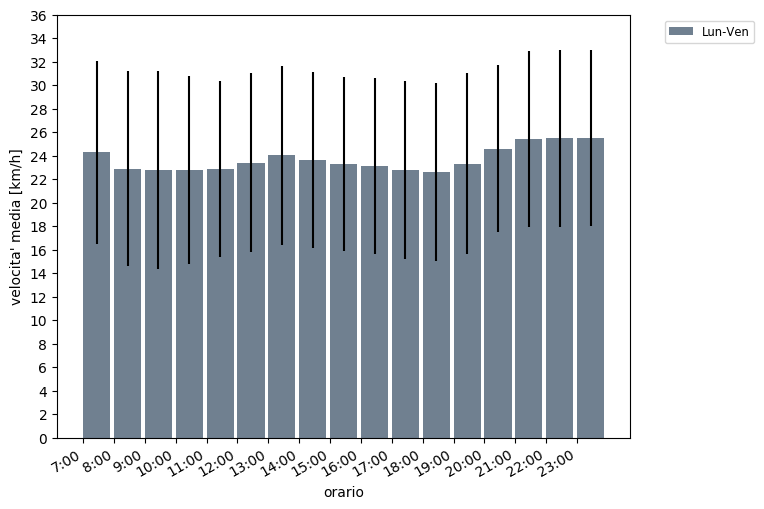

count    46902.000000
mean        23.725357
std          3.951001
min          8.912400
25%         21.062045
50%         23.610862
75%         26.191695
max         59.076545
dtype: float64

In [4]:
tw_means, tw_std = vmedia_week_list(tragitti, 'Car'), np.round(vstd_giorno(tragitti, 'Car'), 1).tolist()

ind = np.arange(len(tw_means))
width = 0.88  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tw_means, width, yerr=tw_std, label='Lun-Ven', color='slategray', align='edge')

fig.tight_layout()

ax.set_xticks(ind)
ax.set_xticklabels(myindex)

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 37, 2))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()


velocita_media = (tragitti[distance_param] * 60.) / tragitti['Car']
velocita_media.describe()

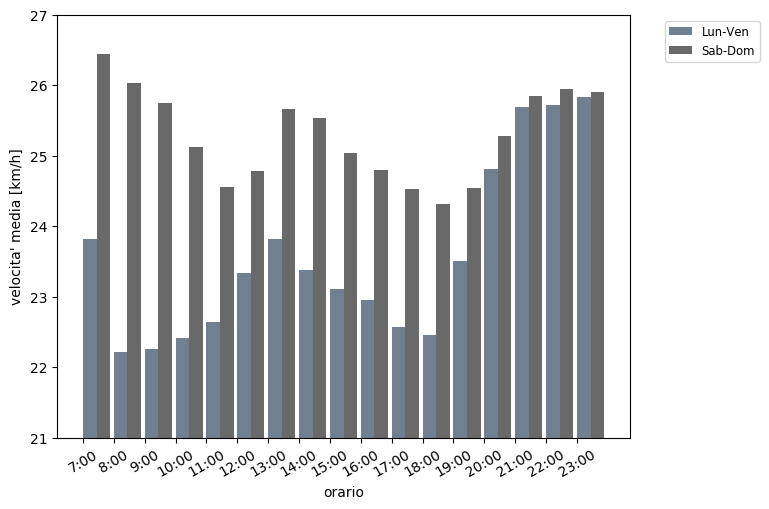

In [5]:
tw_means, tw_std = vmedia_week_list(tragitti[w], 'Car'), np.round(vstd_giorno(tragitti[w], 'Car'), 1).tolist()
twe_means, twe_std =  vmedia_week_list(tragitti[we], 'Car'), np.round(vstd_giorno(tragitti[we], 'Car'), 1).tolist()

ind = np.arange(len(tw_means))
width = 0.44  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tw_means, width, label='Lun-Ven', color='slategray', align='edge')
rects2 = ax.bar(ind + width, twe_means, width, label='Sab-Dom',  color='dimgray', align='edge')

fig.tight_layout()

ax.set_xticks(ind)
ax.set_xticklabels(myindex)

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 29, 1))
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylim((21, 27))

plt.show()

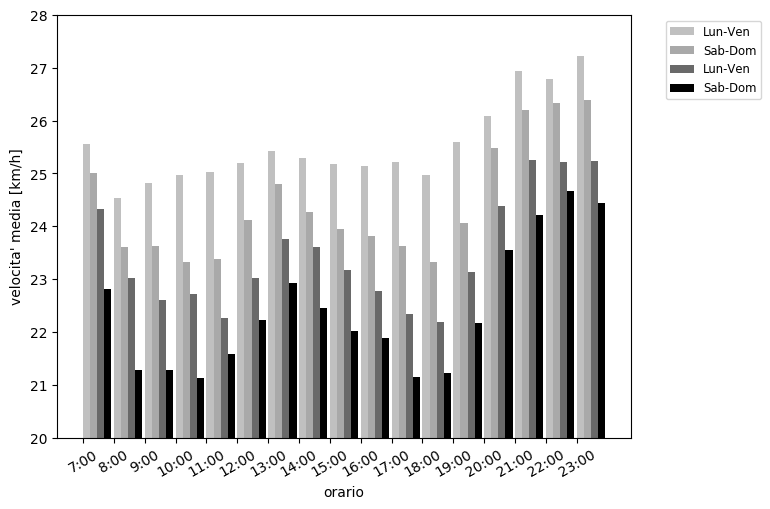

In [6]:
tw12 = vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Car')
tw34 = vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Car')
tw56 = vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Car')
tw78 = vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Car')

ind = np.arange(len(tw12))
width = 0.23  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tw12, width, label='Lun-Ven', color='silver', align='edge')
rects2 = ax.bar(ind + width, tw34, width, label='Sab-Dom',  color='darkgray', align='edge')
rects1 = ax.bar(ind + width * 2, tw56, width, label='Lun-Ven', color='dimgray', align='edge')
rects2 = ax.bar(ind + width * 3, tw78, width, label='Sab-Dom',  color='black', align='edge')

fig.tight_layout()

ax.set_xticks(ind)
ax.set_xticklabels(myindex)

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 29, 1))
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylim((20, 28))

plt.show()